Добрый день!                                                                          
Спасибо за интересное задание!                                                                      
Я принял решение оформить все в формате .ipynb для большей наглядности. Так будут видны результаты работы ячеек и вам не придется их запускать.                                                                               
Если необходимо - могу переделать в формат .py

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
import sklearn.datasets as ds
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import KFold

В этой версии ноутбука реализуем передачу лосс функции как в библиотеке Sklearn, то есть в качестве одного из параметров

При необходимости, здесь можно прописать свою кастомную функцию потерь и добавить в словарь

In [4]:
loss_functions = {
    'ls': mse,
    'lad': mae
}

In [5]:
def mse_grad(y, pred):
    return y - pred

In [6]:
def mae_grad(y, pred):
    return np.sign(y - pred)

In [8]:
gradient_functions = {
    'ls': mse_grad,
    'lad': mae_grad
}

In [9]:
class GradientBoosting():
    def __init__(self, loss = 'ls', criterion = 'mse', n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 17,
                n_samples = 15):
        
        self.loss = loss
        self.criterion = criterion
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.initialization = lambda y: np.mean(y)*np.ones([y.shape[0]])
        self.n_samples = n_samples
        self.trees_ = []
        self.loss_by_iter = []
        self.loss_by_iter_test = []
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)
        prediction = b.copy()
        
        for t in tqdm_notebook(range(self.n_estimators)):
            if t == 0:
                resid = y
            else:
                #получаем значение антиградиента
                resid = gradient_functions[self.loss](y, prediction)
                
            tree = DecisionTreeRegressor(criterion = self.criterion, max_depth = self.max_depth)
            
            # обучаемся на векторе антиградиента
            tree.fit(X, resid)
            # делаем предикт и добавляем алгоритм к ансамблю
            b = tree.predict(X).reshape([X.shape[0]])
            self.trees_.append(tree)
            prediction += self.learning_rate*b
            # добавляем, если итерация не первая 
            if t > 0:
                self.loss_by_iter.append(loss_functions[self.loss](y, prediction))
        return self
        
    def predict(self, X):
        # изначально строим средний вектор ответов на обучении, потом добавляем к нему прогнозы деревьев
        pred = np.ones([X.shape[0]])*np.mean(self.y)
        for t in range(self.n_estimators):
            pred += self.learning_rate*self.trees_[t].predict(X).reshape([X.shape[0]])
        return pred


Для примера возьмем датасет fetch_california_housing и проверим работоспособность алгоритма (а затем и сравним с известными)

In [10]:
data = ds.fetch_california_housing()

In [11]:
X = np.array(data.data)
y = np.array(data.target)

Проверяем работоспособность нашего алгоритма и время его работы

In [12]:
%time
GB = GradientBoosting(loss = 'ls', criterion = 'mse', n_estimators = 50)
GB.fit(X, y)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Аналогично для реализации градиентного бустинга из библиотеки Sklearn

In [13]:
%time
GBSklearn = GradientBoostingRegressor(loss = 'ls', criterion = 'mse', n_estimators = 50)
GBSklearn.fit(X, y)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Сравним время работы алгоритмов на вызове функции предикт

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


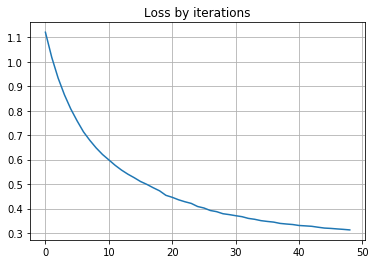

In [14]:
%time
x = GB.predict(X)

plt.grid()
plt.title('Loss by iterations')
plt.plot(GB.loss_by_iter)

In [15]:
%time
x = GBSklearn.predict(X)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


Теперь сравним результаты работы алгоритма

/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/dmitrij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


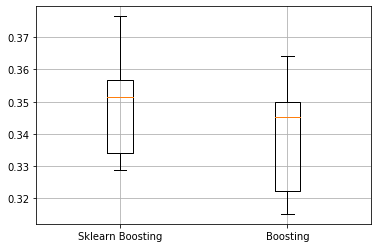

In [17]:
def get_metrics(X,y,n_folds=2, model=None):
    kf = KFold(n_splits=n_folds, shuffle=True)
    kf.get_n_splits(X)

    er_list = []
    for train_index, test_index in tqdm_notebook(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        predict = model.predict(X_test)
        er_list.append(loss_functions['ls'](y_test, predict))
    
    return er_list

er_boosting = get_metrics(X,y,10,GradientBoosting(loss = 'ls', criterion = 'mse', max_depth=3, n_estimators=40))
er_sklearn_boosting = get_metrics(X,y,10,GradientBoostingRegressor(loss = 'ls', criterion = 'mse', max_depth=3, n_estimators=40))

%matplotlib inline
data = [er_sklearn_boosting, er_boosting]
fig7, ax7 = plt.subplots()
ax7.set_title('')
ax7.boxplot(data, labels=['Sklearn Boosting', 'Boosting'])
plt.grid()
plt.show()

*Примечание                                                                
Если в алгоритм установить в качестве criterion = 'mae', то время работы сильно увеличится                                  
Это связано с тем, что процедура обучения обычного дерева на этой функции протекает значительно дольше                          
(Речь идет об этом участке алгоритма:                                                          
tree = DecisionTreeRegressor(criterion = 'mae', max_depth = self.max_depth)                                     
tree.fit(X, resid))